# Работа с временными рядами

https://habr.com/ru/company/ods/blog/327242/

📌 **Временный ряд** - последовательно измеренные через некоторые (зачастую равные) промежутки времини данные.

Обычно в задачах анализа данных предполагается независимость наблюдений. При работе с временными рядами мы строим свой прогноз на основе наблюдений из прошлого.

📌 Компоненты временного ряда:
+ *Тренд* - систематическая линейная или нелинейная компонета, изменяющаяся во времени;
+ *Сезонность* - периодические колебания уровней временного ряда внутри года (например);
+ *Цикл* - периодические колебания, как правило, больше, чем один сезонный период, не имеют определенной продолжительности;
+ *Ошибка* - непрогнозируемая компонента;
+ *Уровень* - среднее значение временного ряда.

In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pylab import rcParams
import warnings
from pandas.core.nanops import nanmean as pd_nanmean

from sklearn.metrics import mean_absolute_error

warnings.filterwarnings('ignore')
%matplotlib inline

Данные о почасовом потреблении энергии от PJM в мегаваттах за более чем 10 лет

https://www.kaggle.com/robikscube/hourly-energy-consumption?select=AEP_hourly.csv

In [2]:
energy_consumption = pd.read_csv('Data/AEP_hourly.csv')
energy_consumption.head(2)

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0


In [3]:
energy_consumption.sort_values('Datetime', axis=0, inplace=True)
energy_consumption = energy_consumption.iloc[-30000:]
energy_consumption['Datetime'] = pd.to_datetime(energy_consumption.Datetime, format='%Y-%m-%d %H:%M:%S')
energy_consumption.index = energy_consumption.Datetime
energy_consumption.drop('Datetime', axis=1, inplace=True)
energy_consumption.head(2)

,AEP_MW
Datetime,
2015-03-02 00:00:00,15867.0
2015-03-02 01:00:00,15444.0


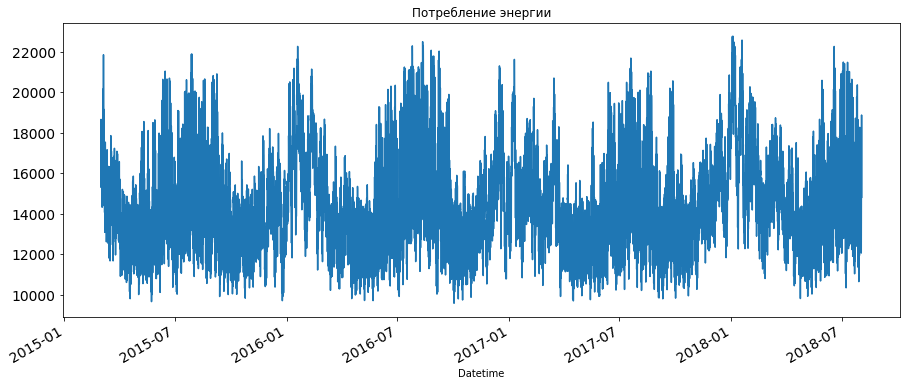

In [4]:
energy_consumption.AEP_MW.plot(figsize=(15, 6), title='Потребление энергии', fontsize=14)

## 1. Компоненты временного ряда

Наш временной ряд раскладывется на отдельные компоненты, работая по отдельности с кождой из них будет проще строить прогноз.

$$Y_t = f(Trend, Seasonality, Cycle, Resid)$$

### 1.1. Тренд

📌 Тренд можно извлечь с помощью **скользящей средней (moving average)** по исходному временному ряду.

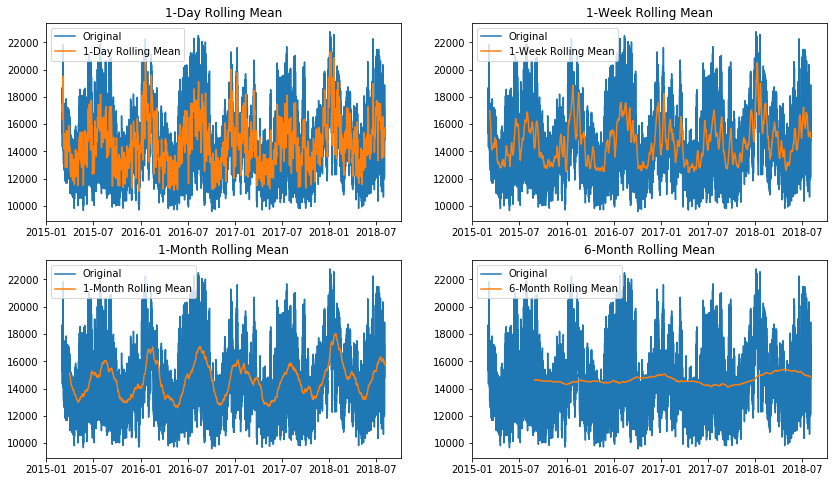

In [17]:
fig, axes = plt.subplots(2, 2, sharey=False, sharex=False)
fig.set_figwidth(14)
fig.set_figheight(8)

window=24
axes[0][0].plot(energy_consumption.index, energy_consumption, label='Original')
axes[0][0].plot(energy_consumption.index, energy_consumption.rolling(window=window).mean(), label='1-Day Rolling Mean')
axes[0][0].set_title('1-Day Rolling Mean')
axes[0][0].legend(loc='best')

window=24*7
axes[0][1].plot(energy_consumption.index, energy_consumption, label='Original')
axes[0][1].plot(energy_consumption.index, energy_consumption.rolling(window=window).mean(), label='1-Week Rolling Mean')
axes[0][1].set_title('1-Week Rolling Mean')
axes[0][1].legend(loc='best')

window=24*30
axes[1][0].plot(energy_consumption.index, energy_consumption, label='Original')
axes[1][0].plot(energy_consumption.index, energy_consumption.rolling(window=window).mean(), label='1-Month Rolling Mean')
axes[1][0].set_title('1-Month Rolling Mean')
axes[1][0].legend(loc='best')

window=24*30*6
axes[1][1].plot(energy_consumption.index, energy_consumption, label='Original')
axes[1][1].plot(energy_consumption.index, energy_consumption.rolling(window=window).mean(), label='6-Month Rolling Mean')
axes[1][1].set_title('6-Month Rolling Mean')
axes[1][1].legend(loc='best')

📌 Чтобы извлечь тренд нужно использовать окно равное сезонности временного ряда (сезонность можно понять как визуально по графику, так и с помощь рядов Фурье)

https://anomaly.io/detect-seasonality-using-fourier-transform-r/index.html

### 1.2. Сезонность

In [18]:
rcParams['figure.figsize'] = 20, 5
energy_consumption['year'] = energy_consumption.index.year
energy_consumption['month'] = energy_consumption.index.month
#сводная таблица
energy_consumption_pivot = pd.pivot_table(energy_consumption, values='AEP_MW', columns='year', index='month') 

In [19]:
energy_consumption.head(2)

,AEP_MW,year,month
Datetime,,,
2015-03-02 00:00:00,15867.0,2015,3
2015-03-02 01:00:00,15444.0,2015,3


In [20]:
energy_consumption_pivot.head(2)

year,2015,2016,2017,2018
month,,,,
1,NaN,16760.747312,15566.197581,17594.87500
2,NaN,15895.386494,14665.684524,15276.66369


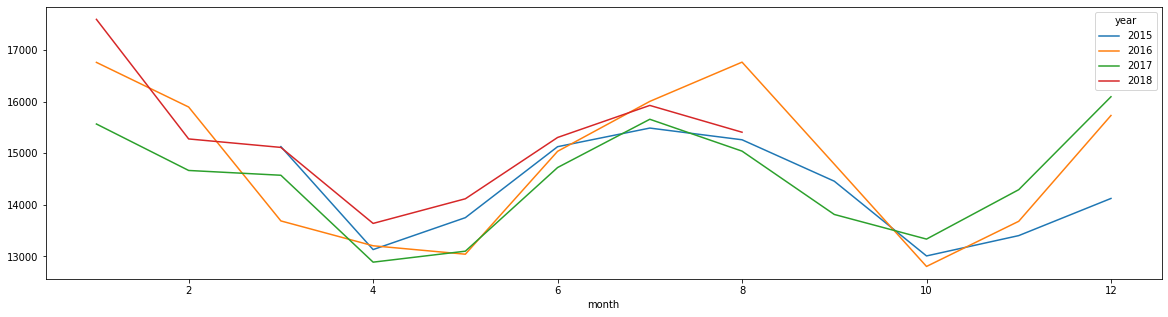

In [21]:
energy_consumption_pivot.plot()

### 1.3. Остатки

То, что осталось после удаления сезонности и тренда, остатки должны напоминать **белый шум**

## 2. Декомпозиция временного ряда

📌 Декомпозиция — разделение целого на части

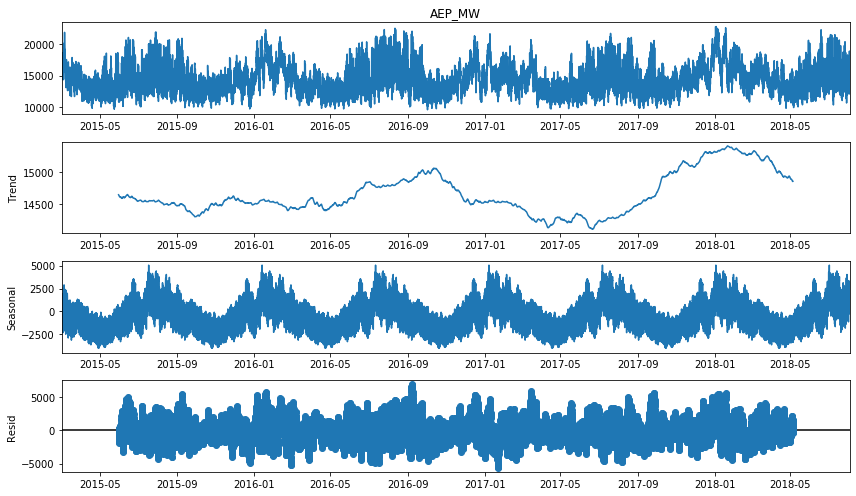

In [22]:
# STL-декомпозиция ряда
rcParams['figure.figsize'] = 12, 7
result = sm.tsa.seasonal_decompose(energy_consumption.AEP_MW, model='additive', freq=24*30*6)
result.plot()
plt.show()

Модели, с помощью которых можно описать временной ряд:

![Models](img/models_time_series.png 'additive-multiplicative')

### Сделаем декомпозицию сами вручную

1) Исходный временной ряд

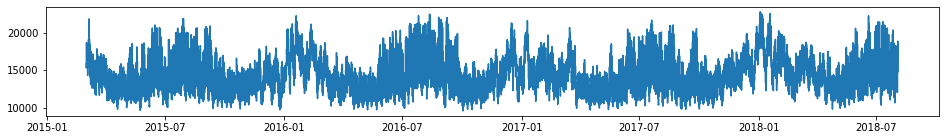

In [7]:
plt.figure(figsize=(16, 2))

plt.plot(energy_consumption.AEP_MW)
plt.show()

2) Плавающее среднее

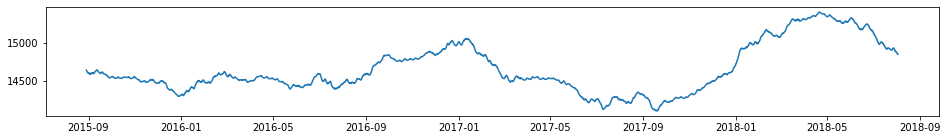

In [8]:
plt.figure(figsize=(16, 2))

MA = energy_consumption.AEP_MW.rolling(window=24*30*6).mean()
plt.plot(MA)
plt.show()

3) Убираем тренд

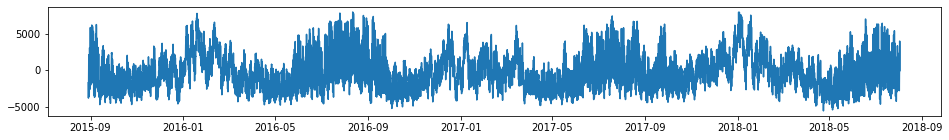

In [9]:
# Чтобы понять модель - смотрим на график
# additive model
detrend_ = energy_consumption.AEP_MW - MA
# multiplicative model
# detrend_ = energy_consumption.AEP_MW / MA
plt.figure(figsize=(16, 2))

plt.plot(detrend_)
plt.show()

4) Нормализуем по дням сезона

In [10]:
def seasonal_mean(x, period):
    """
    Return means for each period in x. period ia an int that gives the
    number of periods per cycle. E.g., 12 for monthly. NaNa are ignored
    in the mean
    """
    return np.array([pd_nanmean(x[i::period], axis=0) for i in range(period)])

In [11]:
#Жестко подвисло при выполнение ячейки на десток минут!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#Видимо много ест памяти компа
s_a = seasonal_mean(detrend_, 24*30*6)
s_a -= np.mean(s_a, axis=0)

nobs = detrend_.shape[0]
seasonal = np.tile(s_a.T, nobs // 24*30*6 + 1).T[:nobs]

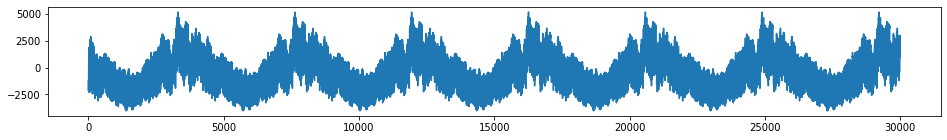

In [12]:
plt.figure(figsize=(16, 2))

plt.plot(seasonal)
plt.show()

5) Остатки

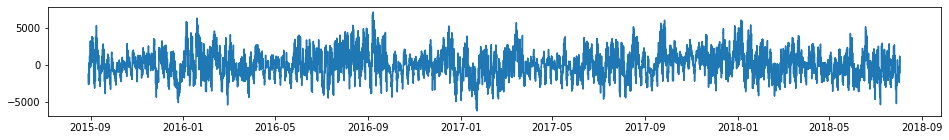

In [13]:
residuals = energy_consumption.AEP_MW - MA - seasonal

plt.figure(figsize=(16, 2))

plt.plot(residuals)
plt.show()

## 3. Предсказание по временному ряду

### 3.1. Наивный подход

"Завтра = вчера"

$$Y_t = Y_{t-n}$$

### 3.2. Предсказание плавающем средним

Новое значение будет вычислятся на основе среднего за конкретный период

$$Y_{t} = \frac{1}{k}\sum_{n=0}^{k-1}Y_{t-n}$$

In [14]:
np.average(energy_consumption[-24:])

15716.166666666666

Можем предсказывать лишь только на один день вперед

### 3.3. Взвешенное среднее

$$Y_{t} = \sum_{n=1}^{k}\omega_nY_{t-n}$$

In [15]:
np.sum(energy_consumption.AEP_MW[-4:] * [0.1, 0.2, 0.3, 0.4])

15843.300000000001

### 3.4. Экспотенциальное сглаживание

Для прогноза будем учитывать все наблюдения, при этом экспотенциально уменьшая веса по мере углубления в исторические данные

$$F_{t}=\alpha \cdot Y_{t} + (1-\alpha )\cdot F_{t-1}$$

In [16]:
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result[-1]    

In [17]:
# Простой пример
series_val = [1, 2, 3, 4, 5, 6]

result = [series_val[0]]

# alpha - насколько сильно мы не хотим помнить, что было в прошлом
alpha = 0.9

for n in range(1, len(series_val)):
    result.append(alpha * series_val[n] + (1 - alpha) * result[n-1])
    
result    

[1, 1.9, 2.89, 3.8890000000000002, 4.8889, 5.88889]

То есть мы строим прогноз как бы учитывая ошибку, которую мы сделали на предыдущем шаге

Две крайности:
+ α = 0 -> прогноз - простое среднее
+ α = 1 -> наивное предсказание

In [10]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [21]:
fit = SimpleExpSmoothing(np.asarray(energy_consumption.AEP_MW)).fit(smoothing_level=0.7, optimized=False)
fit.forecast(0)

array([15261.44014523])

Все рассмотренные способы  не очень подходят для прогнозирования данных с высоким разбросом, не уситываются компоненты временного ряда, могут подойти для прогнозирования на **один** шаг вперед либо для сглаживания.

### 3.5. Двойное экспотенциальное сглаживание

📌 Подходит для работы с временными рядами, где есть устойчивый линейный тренд.

У нас есть следующие компоненты:
+ Линейное уравнение для построения прогноза $$F_{t}=T_{t}+L_{t}$$
+ Уравнеие уровня $$L_{t}=\alpha Y_{t}+(1-\alpha )\cdot (L_{t-1}+T_{t-1})$$
+ Уравнение тренда $$T_{t}=\beta (L_{t}-L_{t-1})+(1-\beta )T_{t-1}$$

α - отвечает за сглаживание

β - отвечает за тренд, с какой силой его учитывать

Итоговое уровнение представляет собой сумму модельных значений уровня и тренда

In [8]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result[-1]

In [9]:
double_exponential_smoothing(energy_consumption.AEP_MW, 0.4, 0.2)

15304.944514776882

In [13]:
fit = Holt(np.array(energy_consumption.AEP_MW)).fit(smoothing_level = 0.4, smoothing_slope=0.2)
fit.forecast(2)[1]

15304.94451477688

### 3.6. Тройное экспотенциальное сглаживание

📌 Учитывает в том числе и сезонность (подходит если сезонность есть)

📌 Мы можем предсказывать уже не на один, и даже не на два, а на произвольные *m* шагов вперёд

Попробуем предскзать потребление энергии за последнюю неделю, отделим *train* и *test*.

In [14]:
train = energy_consumption.AEP_MW.iloc[:-24*7]
test = energy_consumption.AEP_MW.iloc[-24*7:]

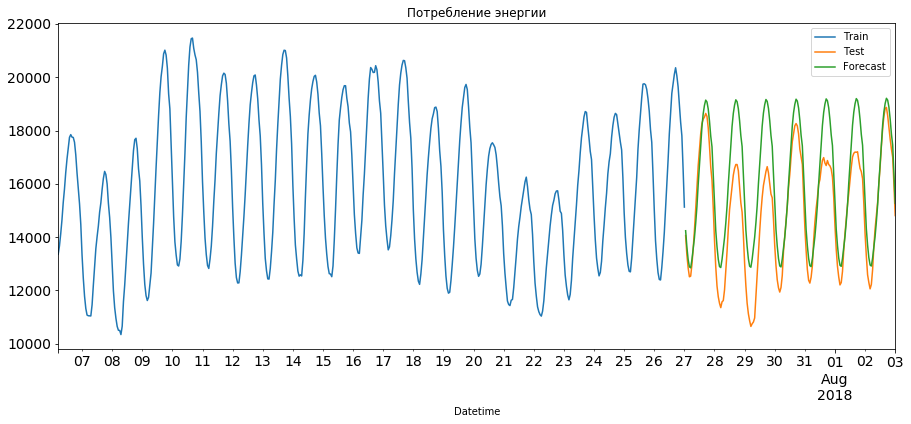

In [20]:
train.iloc[-500:].plot(figsize=(15, 6), title='Потребление энергии', fontsize=14, label='Train')
test.plot(figsize=(15, 6), title='Потребление энергии', fontsize=14, label='Test')
#forecast = test.copy()

fit1 = ExponentialSmoothing(np.asarray(train), seasonal_periods=24, trend='add', seasonal='add').fit()
forecast = pd.Series(fit1.forecast(len(test)))
forecast.index = test.index
forecast.plot(figsize=(15, 6), title='Потребление энергии', fontsize=14, label='Forecast')

plt.legend()

### Как можно померить ошибку?

In [21]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test, forecast)

2017379.998419616

Относительная ошибка - хорошая метрика для бизнеса

In [24]:
def mean_absolute_persentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [25]:
mean_absolute_persentage_error(test, forecast)

7.985059455306802

Алгоритм ошибается на 8%

## 4. Валидация для временного ряда

📌 В реальных задачах у нас нет возможности "заглянуть в будущее", поэтому наша валидация должна поностью повторять ситуацию на тесте.

![Validation](img/cross_validation.png)

In [28]:
from sklearn.model_selection import TimeSeriesSplit
errors = []

tscv = TimeSeriesSplit(n_splits=3)

for train, test in tscv.split(energy_consumption.AEP_MW):

    model = ExponentialSmoothing(np.asarray(energy_consumption.AEP_MW.iloc[train]), seasonal_periods=24, seasonal='add').fit()
    
    forecast = pd.Series(model.forecast(len(test)))
    actual = energy_consumption.AEP_MW.iloc[test]
    error = mean_absolute_persentage_error(actual.values, forecast.values)
    errors.append(error)

In [29]:
errors

[22.0624847097697, 11.180526654479719, 11.579562329728867]

In [30]:
np.mean(errors)

14.940857897992762

## 5. Эконометрический подход

### 5.1. Стационарность

📌 Перед тем как применять статистическую модель для временного ряда необходимо убедиться, что ряд **стационарен**.

**Стационарность** - свойство процесса не менять свои характеристики со временем. Временной ряд стационарен, если его свойста не зависят от времени.

Требования для стационарности:
+ Постоянство матожидания  ![1](img/матожидание.png)
+ Постоянство дисперсии (она же гомоскендатичность) ![2](img/дисперсия.png)
+ Независимость ковариционной функции от времени (должна зависеть только от расстояния между наблюдениями)  ![3](img/ковариация.png)

Зачем?
+ По стационарному ряду просто строить прогноз, так как мы полагаем, что его будущие статистические характеристики не будут отличаться от наблюдаемых текущих.  

Как определить стационарность?
+ Визуально изучить плавающее среднее, плавающее стандартное отклонение;
+ Применить статистический тест **(Дики-Фуллера)**.

In [10]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, window=24, cutoff=0.05):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()
    
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show()
    plt.title('Standard Deviation')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries.values, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]   
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
        
    print(dfoutput)

In [11]:
sample_data = energy_consumption.AEP_MW[-1000:]

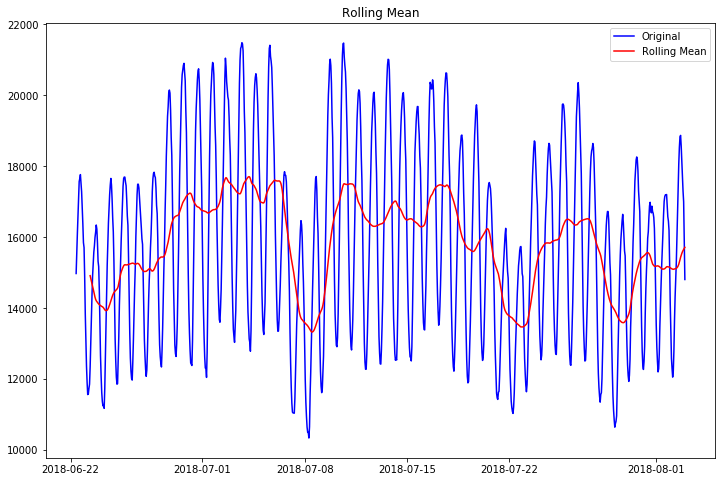

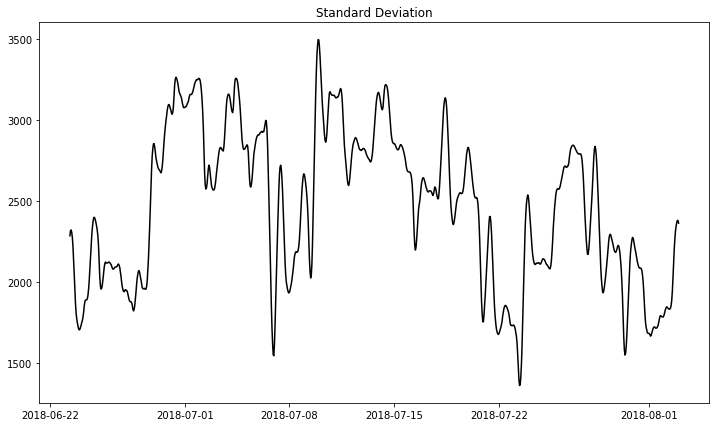

Results of Dickey-Fuller Test:
p-value = 0.0894. The series is likely non-stationary.
Test Statistic                  -2.617696
p-value                          0.089395
#Lags Used                      22.000000
Number of Observations Used    977.000000
Critical Value (1%)             -3.437061
Critical Value (5%)             -2.864503
Critical Value (10%)            -2.568348
dtype: float64


In [12]:
test_stationarity(sample_data)

Временной ряд **нестационарен**.

Подходы для того, чтобы сделать временной ряд стационарным:
+ в случае непостоянства дисперсии - логарифмирование либо преобразование Бокса-Кокса;
+ почти всегда помогает дифференцирование (переход к попарным разностям ряда): стабилизирует среднее зночение ряда, может применяться неоднократно, выделяют также сезонное дифференцирование - попарная разность по сезонам.

### 5.2. Автокорреляция

**Корреляция** (Пирсона) - сила линейной взаимосвязи между двумя случайными велечмнами.

**Автокорреляция** (последовательная корелляция) - корреляция между последовательными показателями, упорядоченными во времени.

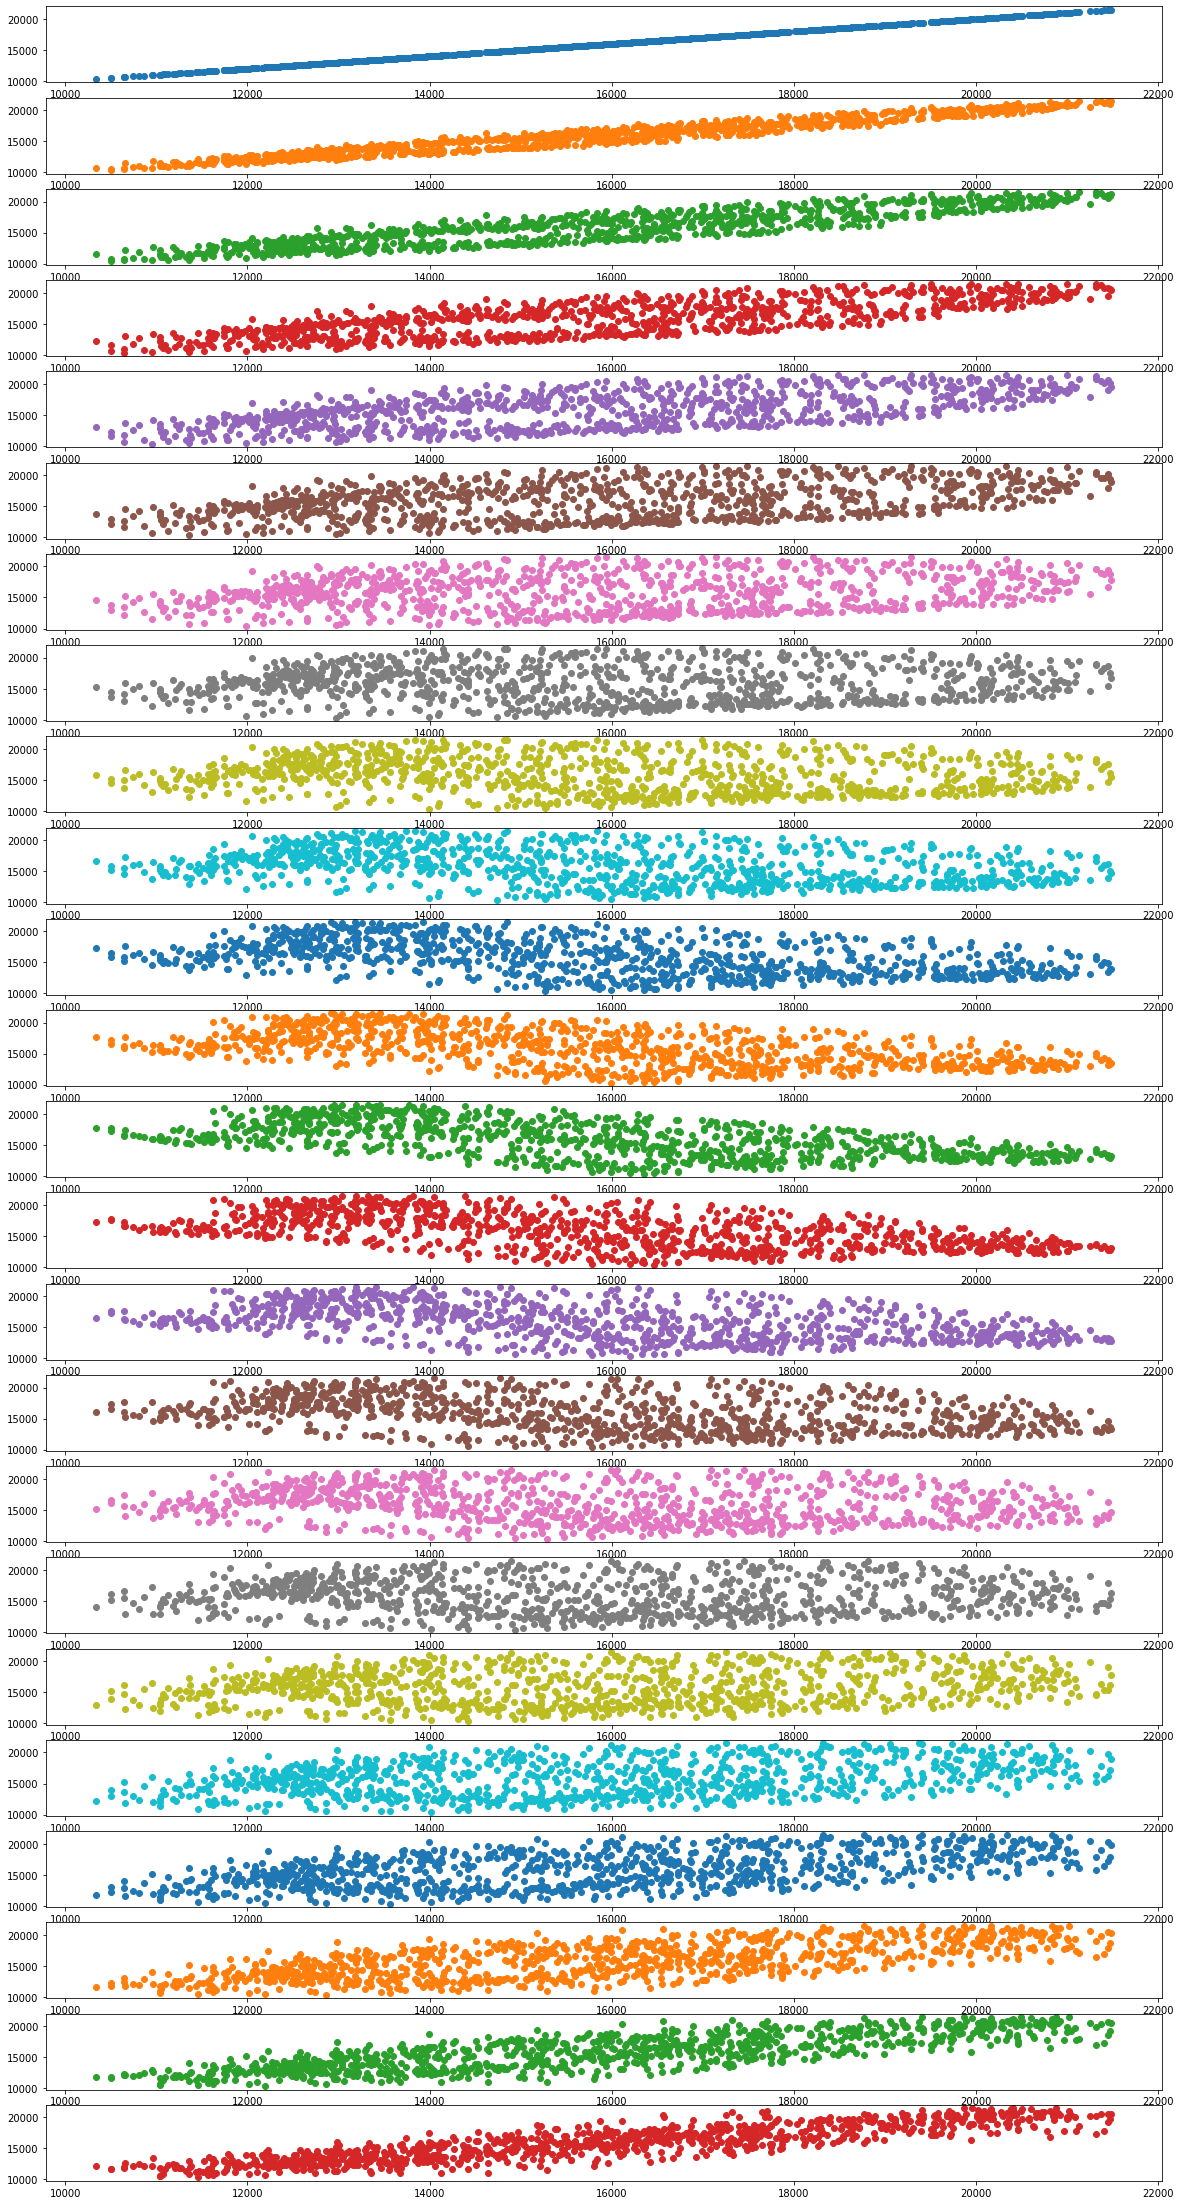

In [18]:
fig, axes = plt.subplots(24,1, figsize=(20,40))
for k, ax in enumerate(axes):
    for i in range(k):
        next(ax._get_lines.prop_cycler)
    ax.plot(sample_data, sample_data.shift(-k), 'o')
    
plt.show()    

Автокорреляция - корреляция между исходным рядом и его версией, который сдвинут на некий лаг **t** (лаг автокорреляции).

![Автокорреляция](img/автокорреляция.png)

### 5.3. ARIMA (SARIMA)

**ARIMA** - AR (Авторегрессия) + I (Интегрирование) + MA (Скользящее среднее)

Будем строить модель **SARIMA**, модель, учитывающая сезонность ряда.

Чтобы строить модель нам нужно знать ее порядок, состоящий из 6 параметров:
+ p,P - порядок компоненты AR;
+ d,D - порядок интегрирования ряда;
+ q,Q - порядок компоненты MA.

*Для p,Р и q,Q надо изучить авторкорреляционную **(АСF)** и частную автокорреляционную **{РАСF)** функции для ряда первых разностей. **АСF** поможет нам определить q и Q, т. к. по ее коррелограмие можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели МА. **РАСF** поможет нам определить р и Р. т. к. по ее коррелограмие можно определить максимальный номер коэффициента сильно отличный от 0 в модели АR.*

![ARIMA](img/ARIMA.png)

<p style='color:#a604c1; font-weight:bold; font-size: 18px;'>1) Интегрирование<p/>

Необходимо избавится от сезонности.

![ARIMA](img/ARIMA2.png)

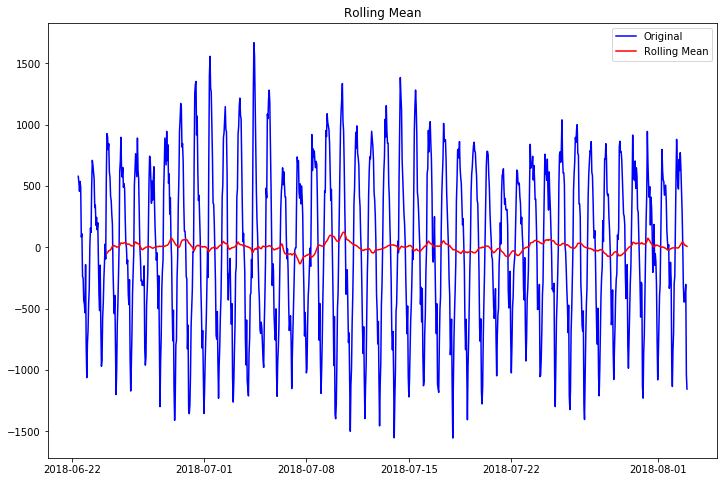

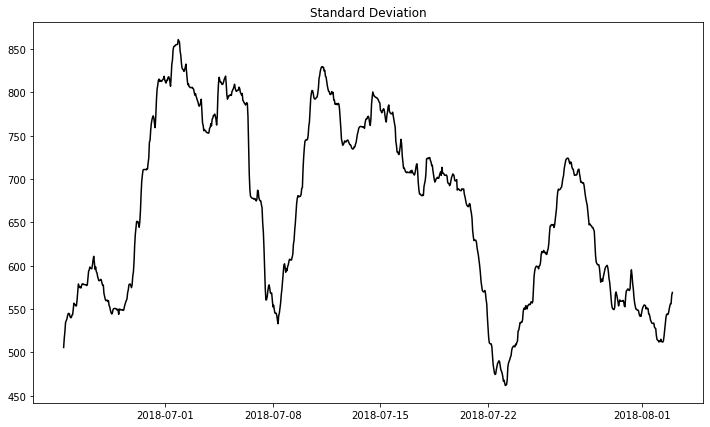

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -5.874538e+00
p-value                        3.182281e-07
#Lags Used                     2.200000e+01
Number of Observations Used    9.760000e+02
Critical Value (1%)           -3.437068e+00
Critical Value (5%)           -2.864506e+00
Critical Value (10%)          -2.568349e+00
dtype: float64


In [13]:
# Дифференцирование
rcParams['figure.figsize'] =12, 7
sample_data_diff = sample_data - sample_data.shift(1)
sample_data_diff.dropna(inplace=True)
test_stationarity(sample_data_diff, window=48)

p-value = 0 -> d=1

**Комонент d = 1, D = 0, так как сезонное дифференцирование мы не делали**

Все же если ряд сезонный, то рекомендуется начинать именно сезонного диффененцирования (D).

Например с лагом 6, если через каждые 6 дней проявляется сезонность, то D=1

<p style='color:#a604c1; font-weight:bold; font-size: 18px;'>2) Авторегрессия (AR - компонент) <p/>

Надо понять влияние прошлых периодов на текущий период.

![AR](img/AR.png)

Модель - линейная комбинация **p** предыдущих значений ряда, шумовой компоненты и константы.

Чтобы определить параметр **р** (найти его приблежение), необходимо обратиться к Частной Автокорреляционной Функции.

**Частичная Автокорреляционная Функция** показывает корреляцию между двумя случайными переменными за вычетом влияния всех внутренних значений автокорреляции. (на картинке - прямой эффект)

Сколько нужно взять предыдущих периодов, чтобы предсказать будущий

![AR](img/AR2.png)

Автокорреляция показывает зависимость между **у4** и **у1**, при этом игнорируя эффект от изменения **у2** и **у3**. А частная автокорреляция также показывает эффект между **у4** и **у1**, при этом учитывая, что эффект от **у2** и **у3** отсутсвует, то есть убирает эффекты **у2** и **у3**.

Рекомендации к подбору первоначальных приближений:

Р(р) - номер последнего сезонного (несезонного) лага, при котором частная автокорреляция значима (персекается граница доверительного интервала), при этом стоит учитывать, что большое число компонентов ведет к увеличению сложности модели и переобучению, если **Р > 0**, то **р** не может быть больше сезонного лага.

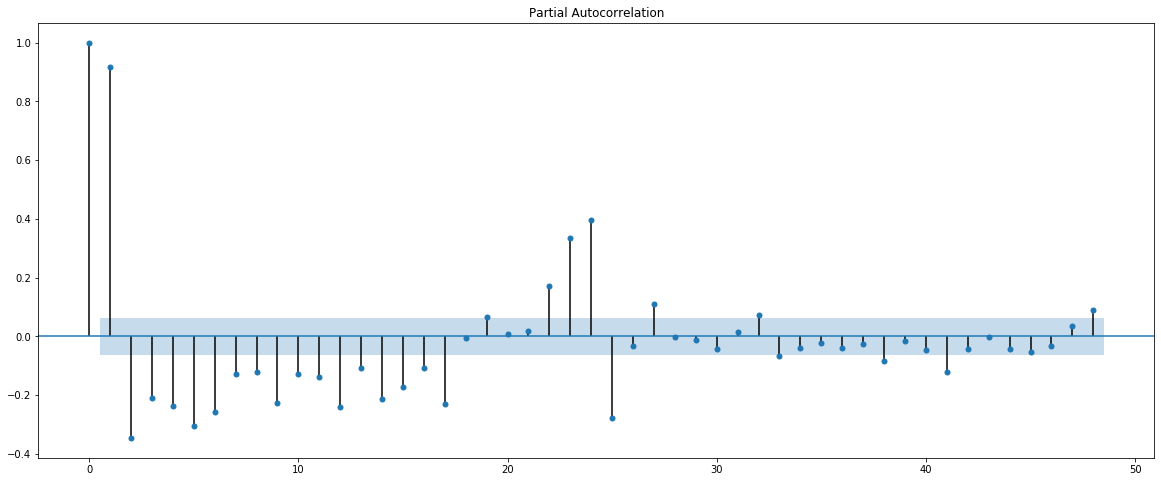

In [18]:
import statsmodels.api as sm

fig, ax = plt.subplots(figsize=(20,8))

sm.graphics.tsa.plot_pacf(sample_data_diff.values, lags=48, ax = ax)
plt.show()

**P** = 1, сезонный лаг равен 24 часам

<p style='color:#a604c1; font-weight:bold; font-size: 18px;'>3) Скользящее среднее (MA - компонент)<p/>

Будем строить модель, как линейную комбинацию **q** последних значений шумовой компоненты. Модель, где используется зависимость между наблюдением и остаточными ошибками от скользящей средней модели применительно к запаздывающим наблюдениям.

![MA](img/MA.png)

**Q(q)** - номер последнего сезонного (несезонного) лага, при котором автокорреляция значима, если **Q > 0**, то **q** не может быть больше сезонного лага.

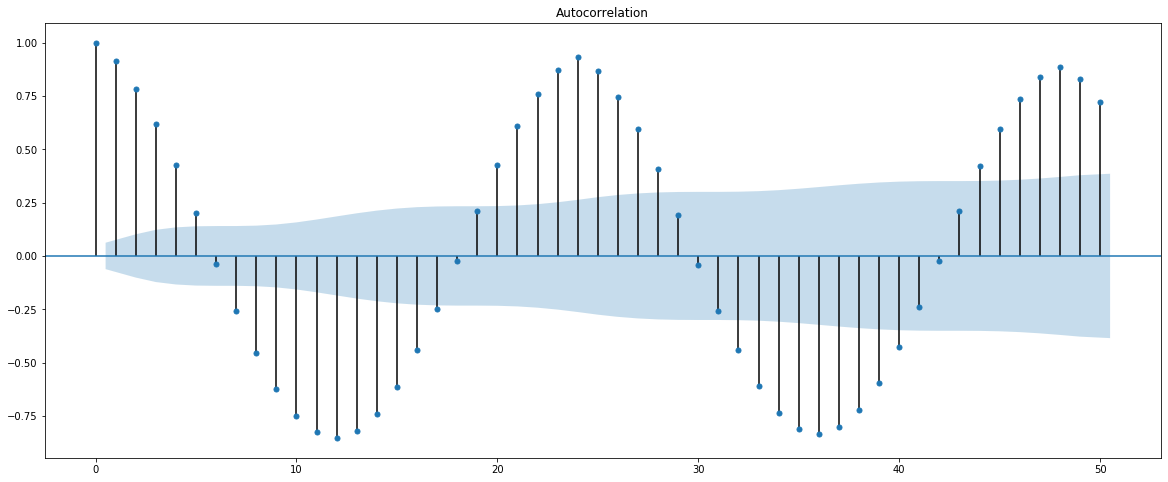

In [19]:
import statsmodels.api as sm

fig, ax = plt.subplots(figsize=(20,8))

sm.graphics.tsa.plot_acf(sample_data_diff.values, lags=50, ax = ax)
plt.show()

<p style='color:#a604c1; font-weight:bold; font-size: 18px;'>4) Построение прогноза<p/>

In [20]:
d = 1
D = 0
s = 24 # сезонность 24 часа

ps = range(0,2)
d = 1
qs = range(0,2)
Ps = range(0,2)
D = 0
Qs = range(0,2)

In [21]:
from itertools import product

parametrs = product(ps, qs, Ps, Qs)
parametrs_list = list(parametrs)
len(parametrs_list)

16

In [28]:
%%time
import warnings
results = []
best_aic = float('inf')
warnings.filterwarnings('ignore')

for param in parametrs_list:
    #try except нужен, потому что нa нeкomopыx нaбopax napanempoв модель He обучается
    try:
        model = sm.tsa.statespace.SARIMAX(sample_data, order=(param[0], d, param[1]),
                                      seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
#Выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong paraneters:', param)
        continue
    aic = model.aic
    #Сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
        
    results.append([param, model.aic])

 
warnings.filterwarnings('default')

Wall time: 1min 9s


In [29]:
print(best_model.summary().tables[0])
print(best_model.summary().tables[1])

                                      SARIMAX Results                                       
Dep. Variable:                               AEP_MW   No. Observations:                 1000
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 24)   Log Likelihood               -6455.642
Date:                              Mon, 30 Nov 2020   AIC                          12919.284
Time:                                      15:26:47   BIC                          12938.911
Sample:                                  06-22-2018   HQIC                         12926.744
                                       - 08-03-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7023      0.018     38.465      0.000       0.667       0.738
ar.S.L24       0.99

Изучим остатки модели, действительно ли они представляют белый шум

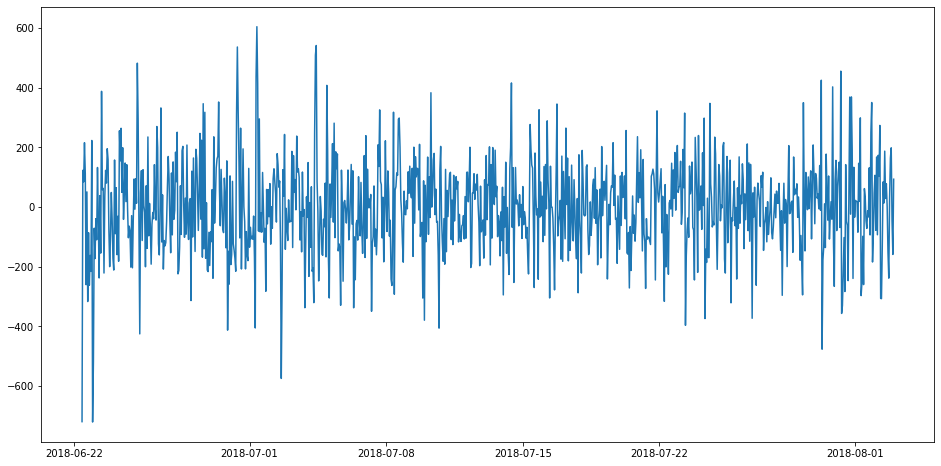

In [32]:
# Остатки модели
plt.figure(figsize=(16,8))
plt.plot(best_model.resid[1:])
plt.show()

Понять что получился белый шум можно при помощи теста Дикка-Фуллера

In [33]:
stat_test = sm.tsa.adfuller(best_model.resid[:])
print('adf: ', stat_test[0] )
print('p-value: ', stat_test[1])
print('Critical values: ', stat_test[4])
if stat_test[0] > stat_test[4]['5%']:
    print ('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

adf:  -12.012978835539373
p-value:  3.149339624956151e-22
Critical values:  {'1%': -3.4370334797663844, '5%': -2.8644907213150725, '10%': -2.568341114581742}
Единичных корней нет, ряд стационарен


In [34]:
forecast = best_model.predict(start=sample_data.shape[0], end=sample_data.shape[0]+24)

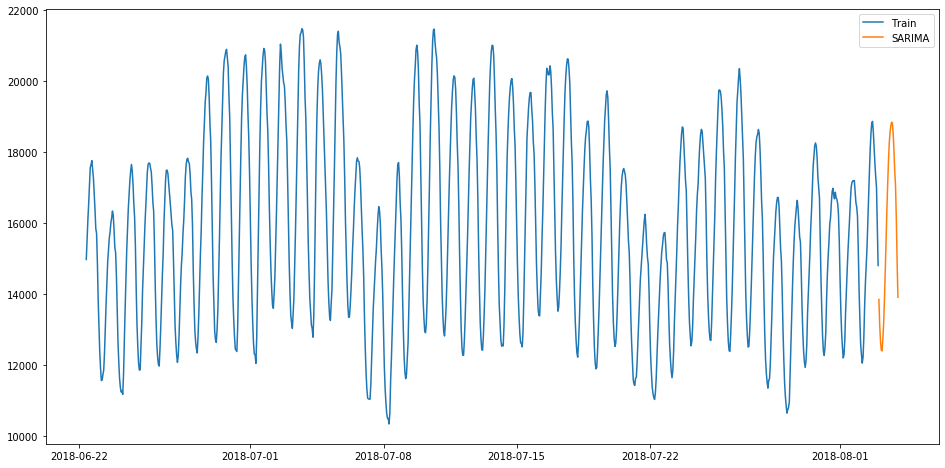

In [35]:
plt.figure(figsize=(16,8))
plt.plot(sample_data, label='Train')
plt.plot(forecast, label='SARIMA')
plt.legend(loc='best')
plt.show()

### 5.4. Линейные модели

Иногда проще всего будет построить линейную модель, включив туда фичи, основанные на времени

+ Лаговые фичи;
+ Статистики по лаговым фичам;
+ Час, день, минута;
+ Праздники, выходные;
+ и т.д.

In [37]:
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression

In [38]:
sample_data_df = pd.DataFrame(sample_data)

date_rng = pd.date_range(start=sample_data_df.index[-1].date(), end=sample_data_df.index[-1].date() + timedelta(days=0, hours=25))
test_period = pd.DataFrame(date_rng[1:], columns = ['datetime'])
test_period.index = test_period.datetime
test_period.drop('datetime', axis = 1, inplace = True)

sample_data_df = pd.concat((sample_data_df,test_period), axis = 0)

In [39]:
sample_data_df.head(5)

,AEP_MW
2018-06-22 09:00:00,14978.0
2018-06-22 10:00:00,15557.0
2018-06-22 11:00:00,16087.0
2018-06-22 12:00:00,16544.0
2018-06-22 13:00:00,17081.0


In [42]:
# лаговые фичи

lag_period = 24

features = []

for period_mult in range(1,10,1):
    sample_data_df["lag_period_{}".format(period_mult)] = sample_data_df.AEP_MW.shift(period_mult*lag_period)
    features.append("lag_period_{}".format(period_mult))

# лаговые статистики
sample_data_df['lagf_min'] = sample_data_df[features].min(axis = 1)
sample_data_df['lagf_max'] = sample_data_df[features].max(axis = 1)
sample_data_df['lagf_mean'] = sample_data_df[features].mean(axis = 1)
sample_data_df['lagf_median'] = sample_data_df[features].median(axis = 1)

features.extend(['lagf_min', 'lagf_max', 'lagf_mean', 'lagf_median'])

In [43]:
train = sample_data_df.iloc[:-24].dropna()
test = sample_data_df.iloc[-24:]

model = LinearRegression()
model.fit(train[features],train['AEP_MW'])
forecast = model.predict(test[features])

In [44]:
test['AEP_MW'] = forecast

C:\Programs\Anaconda\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


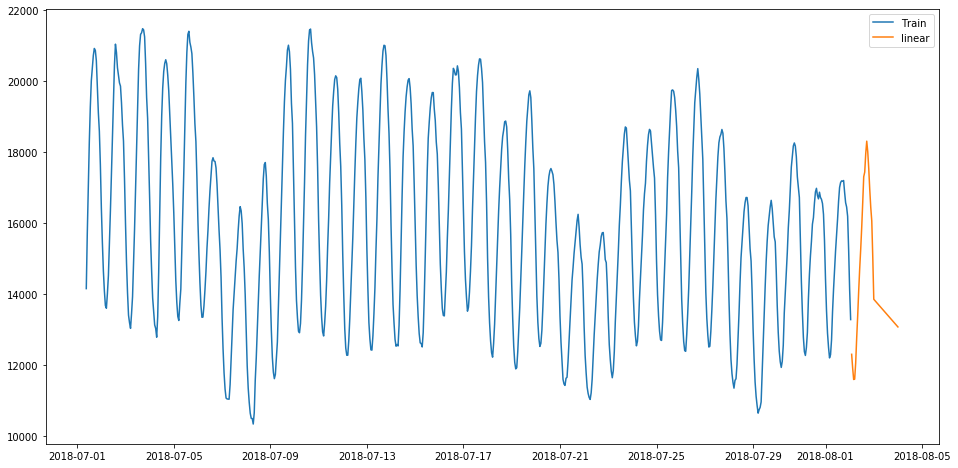

In [45]:
plt.figure(figsize=(16,8))
plt.plot(train.AEP_MW, label='Train')
plt.plot(test.AEP_MW, label='linear')
plt.legend(loc='best')
plt.show()